# Introduction

L'entreprise HumanForYou subit depuis quelques années un turn-over d'environ 15% de ses employés tous les ans et nécessite de retrouver des profils similaires sur le marché de l'emploi. Celle-ci cherche à savoir les raisons de tous ces départs et a fait appel à notre équipe de spécialistes afin d'identifier ces différentes raisons. Ce document va donc présenter le compte rendu de l'analyse des données commandité par la direction de l'entreprise.

# Problématiques générales

- Quels sont les facteurs ayant le plus d'influence sur ce taux de turn-over ?
- Comment réduire ce taux de turn-over ?

# Objectifs

Les deux principaux objectifs de ce document sont de mettre en avant les différentes raisons possibles qui poussent les employés à changer d'entreprise tous les ans et proposer une solution à ce problème.

# Périmètre des données utilisées

Données fondamentales :

- Nombre d'employés : 4410
- Jeux de données au format CSV :
    - Données générales sur les employés : general_data
    - Données du sondage de satisfaction des employés dans l'entreprise : employee_survey_data
    - Données sur les évaluations du manager : manager_survey_data
    - Données sur les horraires d'entrée au bureau : in_time
    - Données sur les horraires de sortie du bureau : out_time

# Plan d'action

Afin de répondre aux problèmatiques, le plan d'action suivant s'est déssiné :
- Étape n°1 - Préparation des données
- Étape n°2 - Explication des indicateurs
- Étape n°3 - Entrainement des modèles
- Étape n°4 - Interprétation des résultats

# Étape n°1 - Préparation des données
## Fonction de sauvegarde des graphiques

Dans le futur, lors de l'affichage des graphiques, ces derniers, par soucis de visibilité, serons enregistrés en local sur l'ordinateur grâce la fonction suivante *save_fig()* : 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

def save_fig(fig_id):
    plt.tight_layout()
    plt.savefig(os.path.join(fig_id + ".png"), format="png", dpi=300)

## Fonction d'importation des données
Actuellement, le jeu de données total est composé de cinq fichiers au format CSV. Ces fichiers sont à importer et à transformer en [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) pandas (bibliothèque Python prévue pour l'analyse et le traitement de données). Pour éviter de dupliquer le code qui importe ces jeux de données, une fonction *load_data()* a été créé afin d'importer un fichier et de le transformer en DataFrame automatiquement.

In [2]:
import os
import pandas as pd

def load_data(file):
    return pd.read_csv(file)

## Importation des données
Comme son nom l'indique, cette partie importe les jeux de données dans des DataFrames sans aucune modification.

In [3]:
path = "./datasets/"
general_data = load_data(path +"general_data.csv")
employee_survey_data = load_data(path +"employee_survey_data.csv")
manager_survey_data = load_data(path +"manager_survey_data.csv")
in_time = load_data(path +"in_time.csv")
out_time = load_data(path +"out_time.csv")

## Jointure des données
Pour la suite du travail, les actions seront effectuées sur une copie du dataset *general_data* afin d'éviter tout soucis.

In [4]:
general_data_copy = general_data.copy()

Maintenant qu'une copie de *general_data* est créée, les deux datasets *employee_survey_data* et *manager_survey_data* sont joints via la colonne "EmployeeID".

Pour rappel :
- *employee_survey_data* contient les réponses au questionnaire du service RH sur la qualité de vie au travail
- *manager_survey_data* contient les évaluations faites par les managers pour chaque employé

In [5]:
general_data_copy = general_data_copy.join(employee_survey_data.set_index("EmployeeID"), on="EmployeeID")

In [6]:
general_data_copy = general_data_copy.join(manager_survey_data.set_index("EmployeeID"), on="EmployeeID")

### Temps
Les deux datasets *in_time* et *out_time*, énumèrent les badges d'entrée et de sortie de chaque employé durant la période du 1er janvier au 31 décembre 2015. Les dates de ces jeux de données seront converties en [datetime](https://docs.python.org/fr/3/library/datetime.html) puis en [timestamp](https://docs.python.org/fr/3/library/datetime.html?highlight=timestamp#datetime.datetime.timestamp) pour les manipuler plus simplement à postériori.

In [7]:
import numpy as np

in_time= in_time.dropna(axis=1, how='all').fillna(0)
out_time = out_time.dropna(axis=1, how='all').fillna(0)

for col in in_time.keys()[1:]:
    in_time[col] = pd.to_datetime(in_time[col]).values.astype(np.int64) // 10 ** 9

for col in out_time.keys()[1:]:
    out_time[col] = pd.to_datetime(out_time[col]).values.astype(np.int64) // 10 ** 9

Une fois cela fait, un tri est effectué afin de les avoir dans l’ordre croissant par rapport à l'identifiant des employés.

In [8]:
in_time = in_time.sort_values(by="Unnamed: 0", ascending=True)
out_time = out_time.sort_values(by="Unnamed: 0", ascending=True)

Par la suite, un calcul sur la différence entre les badges scannés à l'entrée des employés et les badges scannés à la sortie des employés sera effectué pour avoir le temps de travail journalier. 

Avant de faire cela, la colonne des identifiants sera ajoutée à elle-même, cela aura pour effet durant la soustraction des colonnes de garder l'identifiant de l'employé intacte.

In [9]:
out_time["Unnamed: 0"] = out_time["Unnamed: 0"] + out_time["Unnamed: 0"]
time = out_time.subtract(in_time, axis=1)

Une fois le calcul du temps journalier terminé, nous effectuons à nouveau une soustraction, cette fois si entre le temps journalier effectué par l'employé et le temps de travail journalier inscrit dans son contrat.

Par la suite, les valeurs inférieures (les temps de retard) sont remplacées par -1 et les valeurs supérieures (les temps d'heures supplémentaires) sont remplacées par 1.

Enfin, ces valeurs sont additionnées pour obtenir un score  d'assiduité pour chaque employé à l'année, ces valeurs seront stockées dans une colonne appelée *AttendanceScore*.

In [10]:
time_tmp = time.copy()
time_tmp = time_tmp.join(general_data.set_index("EmployeeID"), on="Unnamed: 0")
time_tmp["EmployeeID"] = time_tmp["Unnamed: 0"]
time_tmp["StandardHours"] = time_tmp["StandardHours"] * 3600
time_tmp["AttendanceScore"] = 0

for date in time_tmp.keys()[1:len(time.keys()[1:]) +1]:        
    time_tmp[date] = time_tmp[date] - time_tmp["StandardHours"]
    time_tmp[date] = time_tmp[date].where(time_tmp[date] > 0, -1)
    time_tmp[date] = time_tmp[date].where(time_tmp[date] < 0, 1)
    time_tmp["AttendanceScore"] = time_tmp["AttendanceScore"] + time_tmp[date]

Puis, la colonne *AttendanceScore* est fusionnée au dataset générale via la colonne *EmployeeID*.

In [11]:
general_data_copy = pd.merge(general_data_copy,time_tmp[['EmployeeID', 'AttendanceScore']],on='EmployeeID', how='left')

## Suppression des colonnes
### Éthique
Pour s'assurer de l'éthique des données, il a été décidé de supprimer les colonnes non conformes à l'éthique selon notre jugement. Il a donc été décidé en comparant les recommandations de la Commission Européenne (voir le livrable éthique) de supprimer quatre colonnes : *Age*, *Over18*, *Gender*, *MaritalStatus*.

In [12]:
general_data_copy.drop("Age", axis=1, inplace=True) # Âge
general_data_copy.drop("Over18", axis=1, inplace=True) # Âge
general_data_copy.drop("Gender", axis=1, inplace=True) # Sexe
general_data_copy.drop("MaritalStatus", axis=1, inplace=True) # Statut marital

### Autre
Par la suite, deux autres colonnes ont été supprimées. La première colonne est *EmployeeCount* car il n’existe qu’une seule valeur pour l’ensemble des employés. Ceci implique que la variance de cette colonne est très faible ce qui peut provoquer des résultats faux et un algorithme n'étant pas robuste en cas de nouvelle valeur.

In [13]:
general_data_copy.EmployeeCount.value_counts()

1    4410
Name: EmployeeCount, dtype: int64

La seconde colonne est *StandardHours* (nombre journalier d'heures prévu dans le contrat pour chaque employé), parce qu'elle est elle-même liée à la colonne *AttendanceScore* que nous avons déjà calculée plus tôt.

In [14]:
general_data_copy.drop("EmployeeCount", axis=1, inplace=True)
general_data_copy.drop("StandardHours", axis=1, inplace=True)

## Standardisation des données
### Numérisation des types catégoriels
La standardisation des données va permettre d'utiliser et de manipuler beaucoup plus facilement des données catégorielles. Ces mêmes catégories seront remplacées par des nombres chacun faisant référence à une catégorie bien spécifique. Tout d'abord, les valeurs de la colonne *Attrition* qui sont soit 'Yes', soit 'No', sont repectivement remplacées par les valeurs 1 et -1.

In [15]:
general_data_copy["Attrition"] = general_data_copy["Attrition"].replace(to_replace=['No', 'Yes'], value=[-1, 1])

Pour réaliser cela, il est courant d'utiliser des encodeurs tels que l'[OrdinalEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html). Celui-ci permet notamment de transformer nos catégories en nombres numérotés automatiquement.

Exemple : "gauche", "droite" et "devant" en 0, 1 et 2 respectivement.

In [16]:
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

general_data_copy.EducationField = ordinal_encoder.fit_transform(general_data_copy[["EducationField"]])
general_data_copy.BusinessTravel = ordinal_encoder.fit_transform(general_data_copy[["BusinessTravel"]])
general_data_copy.Department = ordinal_encoder.fit_transform(general_data_copy[["Department"]])
general_data_copy.JobRole = ordinal_encoder.fit_transform(general_data_copy[["JobRole"]])

### Transformation diverse des données
La colonne *PercentSalaryHike* étant un pourcentage, celle-ci est réduite en divisant ses valeurs par 100, ce qui permet de créer une meilleure échelle de comparaison par rapport aux autres colonnes.

In [17]:
general_data_copy["PercentSalaryHike"] = general_data_copy["PercentSalaryHike"] / 100

## Nettoyage des données

Puis les valeurs de type NaN (donnée vide) sont remplacé par 0.

In [18]:
general_data_copy = general_data_copy.fillna(0)

## Corrélation

Maintenant que toutes les données sont mises en forme, des calculs de corrélations entre les colonnes sont implémentés. Le but étant de proposer un premier aperçu des raison possibles de ce turn-over qui sera confirmé à la fin de ce présent document.

### Méthode aidant à la visualisation de la corrélation

 La fonction *retain_terminal* prend en paramètre un DataFrame et va appliquer un filtre afin de remplacer les valeurs comprises entre -0.1 et 0.1 par 0. Ceci va permettre de visualiser beaucoup plus facilement les colonnes les plus influentes (s'éloignant d'un score de corrélation de 0).

In [19]:
def retain_terminal(frame):
    for i in frame.keys():
        for a in range(len(frame[i])):
            if frame[i][a] > 0.1 or frame[i][a] < -0.1:
                frame[i][a] = frame[i][a]
            else:
                frame[i][a] = 0
    return frame

La fonction *separation_significant_parameters* vient en complément de la fonction précédente, celle-ci permet de séparer les paramètres considérés comme significatifs et qui n'auront donc pas été remplacés par 0 et les paramètres non significatifs qui auront été remplacés par 0.

In [20]:
def separation_significant_parameters(frame):
    significient_parameter = []
    insignificient_parameter = []
    for i in frame.keys():
        if frame[i].value_counts()[0] == len(frame[i]) - 1:
            insignificient_parameter.append(i)
        else:
            significient_parameter.append(i)
    return significient_parameter, insignificient_parameter

### Calculs et visualisation des corrélations
Ensuite, l'ensemble des corrélations sont calculées avec la méthode [Pearson](http://www.biostat.ulg.ac.be/pages/Site_r/corr_pearson.html).

In [21]:
corr_data = general_data_copy.corr()

Le filtre précédemment défini est appliqué afin de supprimer le bruit (valeur entre -0.1 et 0.1) pour mieux visualiser les corrélations fortes.

In [22]:
corr_data = retain_terminal(corr_data)

Une fois que les corrélations ont été calculées, une visualisation est créée à l'aide d'une [HeatMap](https://seaborn.pydata.org/generated/seaborn.heatmap.html). Une HeatMap permet d'afficher des résultats avec différentes couleurs en fonction de la valeur de ce résultat et permet également d'afficher une annotation pour vérifier le score de corrélation.

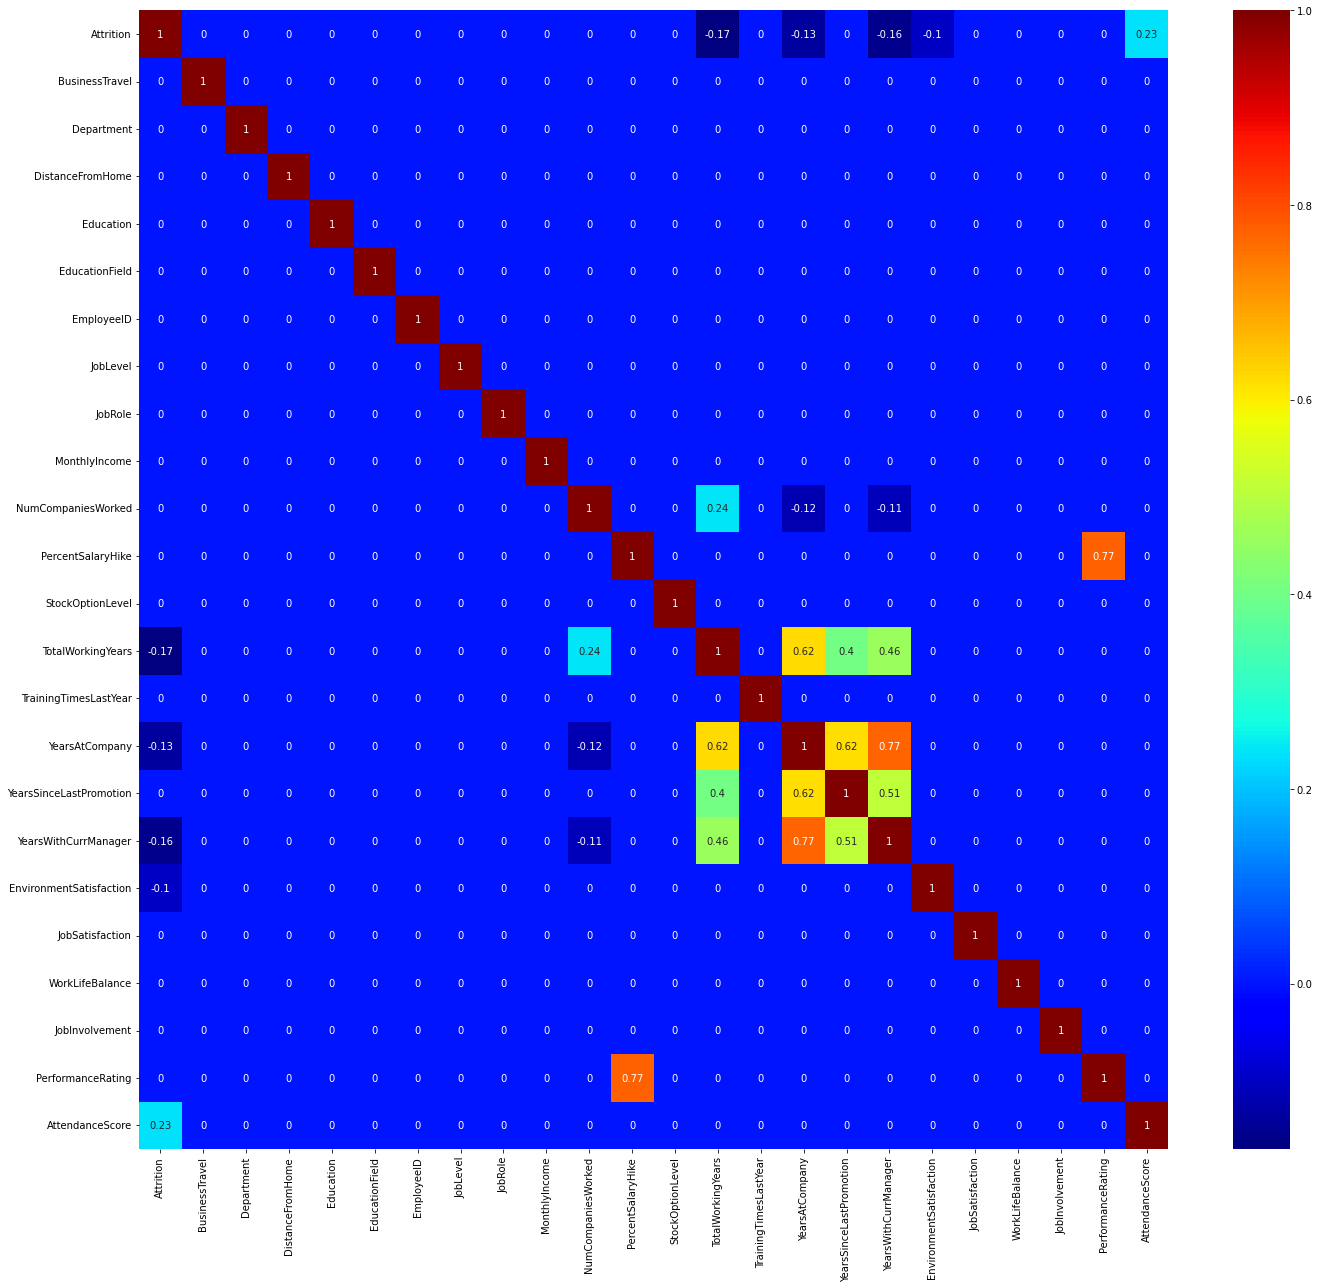

In [23]:
plt.figure(figsize=(20,18))
sns.heatmap(corr_data, annot = True, cmap=plt.get_cmap("jet"))
save_fig("./outputs/heatmap_correlation_pearson-jet")

Sur la HeatMap, certaines colonnes peuvent d'ores et déjà être enlevées, car elles ne sont pas corrélées entre-elles. Les colonnes supprimées seront donc les suivantes :
- BusinessTravel,
- Department,
- DistanceFromHome,
- Education,
- EducationField,
- EmployeeID,
- JobLevel,
- JobRole,
- MonthlyIncome,
- StockOptionLevel,
- TrainingTimesLastYear,
- JobSatisfaction,
- WorkLifeBalance,
- JobInvolvement.

Le but est de ne pas fournir trop de paramètres différents et non pertinents à notre algorithme afin d'obtenir des resultats fiables et un modèle prédictif performant.

La méthode *separation_significant_parameters* est maintenant utilisée afin de retourner les paramètres significatifs et insignifiants dans deux [tuples](https://courspython.com/tuple.html) différents. Les paramètres insignifiants sont identiques à ceux retournés par la méthode.

In [24]:
significant_parameter, insignificant_parameter = separation_significant_parameters(corr_data)
insignificant_parameter

['BusinessTravel',
 'Department',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EmployeeID',
 'JobLevel',
 'JobRole',
 'MonthlyIncome',
 'StockOptionLevel',
 'TrainingTimesLastYear',
 'JobSatisfaction',
 'WorkLifeBalance',
 'JobInvolvement']

Une nouvelle HeatMap avec uniquement les corrélations les plus fortes est générée avec le même traitement que le précédent.

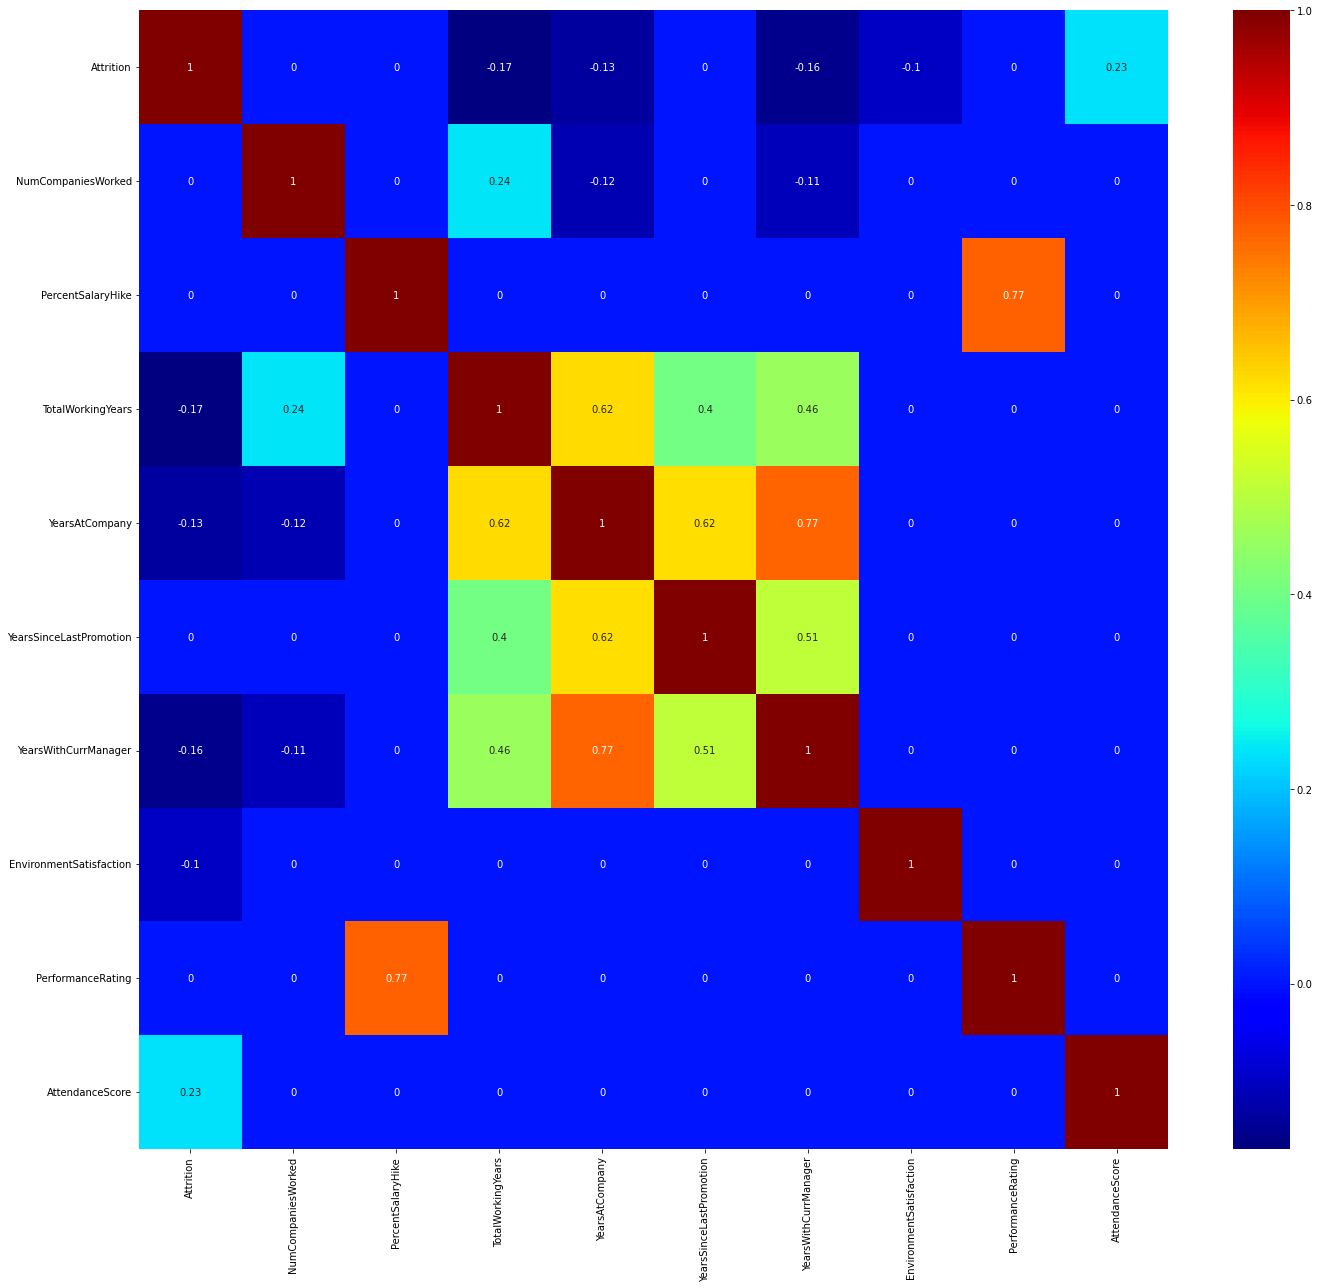

In [25]:
corr_tmp = general_data_copy[significant_parameter].corr()
corr_tmp = retain_terminal(corr_tmp)

plt.figure(figsize=(20,18))
sns.heatmap(corr_tmp, annot = True, cmap=plt.get_cmap("jet"))#, mask=np.triu(np.ones_like(corr_tmp, dtype=bool)))
save_fig("./outputs/heatmap_correlation_pearson-jet-without-columne")

Enfin, le jeu de données est donc modifié une dernière fois pour ne garder que les valeurs de la colonne *Attrition* dont la corrélation est différente de 0.

In [26]:
general_data_copy = general_data_copy[corr_tmp.Attrition[corr_tmp.Attrition != 0].keys()]
general_data_copy

,Attrition,TotalWorkingYears,YearsAtCompany,YearsWithCurrManager,EnvironmentSatisfaction,AttendanceScore
0,-1,1.0,1,0,3.0,-249
1,1,6.0,5,4,3.0,-165
2,-1,5.0,5,3,2.0,-249
3,-1,13.0,8,5,4.0,-249
4,-1,9.0,6,4,4.0,-19
...,...,...,...,...,...,...
4405,-1,10.0,3,2,4.0,225
4406,-1,10.0,3,2,4.0,-249
4407,-1,5.0,4,2,1.0,-167
4408,-1,10.0,9,8,4.0,233


## Création de la pipeline de préparation
L’objectif de cette partie était de transformer les données et les DataFrames dans le but d’avoir un jeu de données préparé et utilisable. Ces classes reprennent les étapes décrites précédemment. Ce regroupement (pipeline) permettra de faire appel beaucoup plus facilement à ces opérations de transformation des données. Ceci est notamment utile lors de l'importation d'un jeu de données avec des colonnes identiques mais des données différentes qui doivent, elles aussi, être préparées pour une exploitation future.

In [27]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class mergeDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, employee_survey_data, manager_survey_data, in_time, out_time):
        self.employee_survey_data = employee_survey_data
        self.manager_survey_data = manager_survey_data
        
        self.in_time= in_time.dropna(axis=1, how='all').fillna(0)
        self.out_time = out_time.dropna(axis=1, how='all').fillna(0)
        
        for col in self.in_time.keys()[1:]:
            self.in_time[col] = pd.to_datetime(self.in_time[col]).values.astype(np.int64) // 10 ** 9
        self.in_time = self.in_time.sort_values(by="Unnamed: 0", ascending=True)
        
        for col in self.out_time.keys()[1:]:
            self.out_time[col] = pd.to_datetime(self.out_time[col]).values.astype(np.int64) // 10 ** 9
        self.out_time["Unnamed: 0"] = self.out_time["Unnamed: 0"] + self.out_time["Unnamed: 0"]
        self.out_time = self.out_time.sort_values(by="Unnamed: 0", ascending=True)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X = X.join(self.employee_survey_data.set_index("EmployeeID"), on="EmployeeID")
        X = X.join(self.manager_survey_data.set_index("EmployeeID"), on="EmployeeID")
        
        time = self.out_time.subtract(self.in_time, axis=1)
        
        time_tmp = time.copy()
        time_tmp = time_tmp.join(X.set_index("EmployeeID"), on="Unnamed: 0")
        time_tmp = time_tmp.rename(columns={"Unnamed: 0": "EmployeeID"})
        time_tmp["StandardHours"] = time_tmp["StandardHours"] * 3600
        time_tmp["AttendanceScore"] = 0
        
        for date in time_tmp.keys()[1:len(time.keys()[1:]) +1]:        
            time_tmp[date] = time_tmp[date] - time_tmp["StandardHours"]
            time_tmp[date] = time_tmp[date].where(time_tmp[date] > 0, -1)
            time_tmp[date] = time_tmp[date].where(time_tmp[date] < 0, 1)
            time_tmp["AttendanceScore"] = time_tmp["AttendanceScore"] + time_tmp[date]
        
        X = pd.merge(X, time_tmp[['EmployeeID', 'AttendanceScore']], on='EmployeeID', how='left')
        
        return X

In [28]:
class deleteEthicColumn(BaseEstimator, TransformerMixin):
    def __init__(self, array):
        self.array = array
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for i in self.array:
            X.drop(i, axis=1, inplace=True)
        return X

In [29]:
from sklearn.preprocessing import OrdinalEncoder

class convertDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X["Attrition"] = X["Attrition"].replace(to_replace=['No', 'Yes'], value=[-1, 1])
        ordinal_encoder = OrdinalEncoder()
        for i in X.select_dtypes(include=["object"]).keys():
            X[i] = ordinal_encoder.fit_transform(X[[i]])
        return X

In [30]:
class cleaningDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        X.PercentSalaryHike = X.PercentSalaryHike / 100
        X = X.fillna(0)
        return X

In [31]:
class corrDataFrame(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        corr_x = self.retain_terminal(X.corr())
        significient_parameter, insignificient_parameter = self.separation_significant_parameters(corr_x)
        
        corr_tmp = X[significant_parameter].corr()
        corr_tmp = retain_terminal(corr_tmp)
                        
        return X[corr_tmp.Attrition[corr_tmp.Attrition != 0].keys()]
        
    def retain_terminal(self, frame):
        for i in frame.keys():
            for a in range(len(frame[i])):
                if frame[i][a] > 0.1 or frame[i][a] < -0.1:
                    frame[i][a] = frame[i][a]
                else:
                    frame[i][a] = 0
        return frame
    
    def separation_significant_parameters(self, frame):
        significient_parameter = []
        insignificient_parameter = []
        for i in frame.keys():
            if frame[i].value_counts()[0] == len(frame[i]) - 1:
                insignificient_parameter.append(i)
            else:
                significient_parameter.append(i)
        return significient_parameter, insignificient_parameter

Le code suivant décrit toutes les étapes que le pipeline exécutera pour obtenir le datasets complet et final.

In [32]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ("merge", mergeDataFrame(load_data(path +"employee_survey_data.csv"),
                             load_data(path +"manager_survey_data.csv"),
                             load_data(path +"in_time.csv"),
                             load_data(path +"out_time.csv"))),
    ("delete", deleteEthicColumn([
        "Age",
        "Over18",
        "Gender",
        "MaritalStatus",
        "EmployeeCount",
        "StandardHours"
    ])),
    ("convert", convertDataFrame()),
    ("clean", cleaningDataFrame()),
    ("corr", corrDataFrame())
])

Le pipeline est exécuté, puis le résultat est séparé en deux variables, la première *X* sont les paramètres donnés en entrée des modèles et le deuxième *y* le résultat attendu en sorti du modèle. Ces valeurs sont ensuite affichées.

In [33]:
dataset = pipeline.fit_transform(
    load_data(path +"general_data.csv")
)
    
labels = dataset.keys().to_list()
labels.remove('Attrition')
    
X = dataset[labels]
y = dataset['Attrition']
X

,TotalWorkingYears,YearsAtCompany,YearsWithCurrManager,EnvironmentSatisfaction,AttendanceScore
0,1.0,1,0,3.0,-249
1,6.0,5,4,3.0,-165
2,5.0,5,3,2.0,-249
3,13.0,8,5,4.0,-249
4,9.0,6,4,4.0,-19
...,...,...,...,...,...
4405,10.0,3,2,4.0,225
4406,10.0,3,2,4.0,-249
4407,5.0,4,2,1.0,-167
4408,10.0,9,8,4.0,233


In [34]:
# Target
y

0      -1
1       1
2      -1
3      -1
4      -1
       ..
4405   -1
4406   -1
4407   -1
4408   -1
4409   -1
Name: Attrition, Length: 4410, dtype: int64

# Étape n°2 - Explication des indicateurs


Les indicateurs que nous utiliserons afin de vérifier les performances de notre modèle final sont présentés dans cette partie. Ces notions sont cruciales à comprendre et constituent ici une introduction à l'exploitation et l'interprétation finale de l'étude.
Il est à noter que les fonctions utilisent à la fois la bibliothèque [scikit-learn](https://scikit-learn.org/stable/) (sklearn) mais également des fonctions réalisées sans l'utilisation de bibliothèque spécifique afin de vérifier nos résultats et la bonne compréhension des métriques.

## Définition

En Machine Learning, la bonne manière de procéder consiste à se baser sur des indicateurs mathématiques précis et concrets ouvrant la porte aux interprétations humaines. Généralement dans ce type de problèmes de classification, des indicateurs tels que des métriques de performance ou encore des courbes de comparaisons sont très utilisés.

Chaque indicateur de cette partie sera donc accompagnée d'une rapide description ainsi qu'une explication sur son utilisation et sur le résultat obtenu dans notre contexte.

![](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRaefwz7ZSNyFZeO8Urtnjj58MgDKFzRV5aE0WNoXNn6ejBy3ZvVDwQVL8N081CpvTfOJY&usqp=CAU)

## Données de test

Afin de se concentrer uniquement sur la bonne compréhension des indicateurs, des résultats de modèles ont été crées et seront utilisés dans les prochains calculs : 

In [35]:
virtual_resultat = [1, 1, 1, 1, -1, -1, -1, -1, -1, 1]
virtual_prediction = [1, 1, 1, 1, 1, 1, 1, -1, -1, -1]

## Matrice de confusion

La matrice est de confusion est aujourd'hui l'un des outils les plus utilisés pour évaluer les performances d'un modèle de classification. Celle-ci présente un système de classes associées chacune à une valeur de représentation de cette classe suite à l'entrainement avec un modèle de prédictions. Il est à noter que ce type de matrice fonctionne aussi bien pour des problèmes de classification à 2 classes (binaires) ou plus.

Veuillez trouver ci-dessous un exemple de matrice de prédiction binaire :
![](https://docs.microsoft.com/fr-fr/dynamics365/finance/finance-insights/media/tn-fn.png)

Comme présenté dans la figure, dans le cas binaire les classes sont : 

- ***TP*** : les valeurs prédites positives par le modèle et qui se trouvent être positives au final (bonne prédiction)
- ***TN*** : les valeurs prédites positives par le modèle et qui se trouvent être négatives au final (mauvaise prédiction)
- ***FP*** : les valeurs prédites négatives par le modèle et qui se trouvent être positives au final (mauvaise prédiction)
- ***FN*** : les valeurs prédites négatives par le modèle et qui se trouvent être négatives au final (bonne prédiction)

### Méthode "sklearn"

In [36]:
from sklearn.metrics import confusion_matrix

confusion_matrix(virtual_resultat, virtual_prediction)

array([[2, 3],
       [1, 4]], dtype=int64)

### Méthode "homemade"

In [37]:
import numpy as np
def homemade_confusion_matrix(y, predict):    
    values_y = np.unique(y)[::-1]
    
    matrix = np.zeros((len(values_y), len(values_y)), dtype=int)
    for i in range(len(y)):
        matrix[np.where(values_y == y[i])[0][0]][np.where(values_y == predict[i])[0][0]] += 1
    
    return matrix

In [38]:
homemade_confusion_matrix(virtual_resultat, virtual_prediction)

array([[4, 1],
       [3, 2]])

La matrice de confusion retournée par le code n'utilisant pas de bibliothèque n'affiche pas les valeurs dans l'ordre de celui avec bibliothèque. Il a été choisi de conserver l'ordre de la figure ci-dessus pour les *TP, TN, FP, FN* à des fins de compréhension.
Quoi qu'il en soit, les valeurs sont évidemment les mêmes et sont correctes.

## Métriques de performance

Une fois la matrice de confusion construite, les indicateurs peuvent maintenant se calculer. Ceux présentés dans cette partie sont ceux considérés comme les plus utiles pour l'étude et qui seront abordés dans la dernière partie.

### Sensibilité, Recall, TPR : True Positive Rate
Cette métrique de performance représente le pourcentage d'employés quittant l'entreprise et étant bien détectés comme partant l'entreprise.
$$Recall = {{TP} \over {TP \, + \, FN}}$$
#### Méthode "sklearn"

In [39]:
from sklearn.metrics import recall_score

recall = recall_score(virtual_resultat, virtual_prediction)
print(recall)

0.8


#### Méthode "homemade"

In [40]:
def homemade_recall_score(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[0][0]) / (matrix[0][0] + matrix[0][1])

In [41]:
recall = homemade_recall_score(virtual_resultat, virtual_prediction)
print(recall)

0.8


### Spécificité, TNR : True Negative Rate

Cette métrique de performance représente le pourcentage d'employés restant dans l'entreprise et donc les employés étant bien détéctés comme restant l'entreprise.

$$TNR = {{TN} \over {TN \, + \, FP}}$$

#### Méthode "homemade"

In [42]:
def homemade_specificity_score(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[1][1]) / (matrix[1][1] + matrix[1][0])

In [43]:
homemade_specificity_score(virtual_resultat, virtual_prediction)

0.4

### Fall out, FPR : False Positive Rate

Cette métrique de performance représente le pourcentage d'employés quittant l'entreprise, mais étant détectés comme restant dans l'entreprise.

$$FPR = {{FP} \over {TN \, + \, FP}}$$

#### Méthode "homemade"

In [44]:
def homemade_fpr_calculator(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[1][0]) / (matrix[1][0] + matrix[1][1])

In [45]:
fpr = homemade_fpr_calculator(virtual_resultat, virtual_prediction)
print(fpr)

0.6


### FNR : False negative Rate

Cette métrique de performance représente le pourcentage d'employés restant dans l'entreprise, mais étant détectés comme quittant l'entreprise.

$$FNR = {{FN} \over {FN \, + \, TP}}$$

#### Méthode "homemade"

In [46]:
def homemade_fnr_calculator(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[0][1]) / (matrix[0][0] + matrix[0][1])

In [47]:
homemade_fnr_calculator(virtual_resultat, virtual_prediction)

0.2

### Précision, PPV : Positive Preditive Value

La valeur de prédiction positive représente le pourcentage de prédictions positives étant réellement correctes.

$$Precision = {{TP} \over {TP+FP}}$$

#### Méthode "sklearn"

In [48]:
from sklearn.metrics import precision_score

precision = precision_score(virtual_resultat, virtual_prediction)
print(precision)

0.5714285714285714


#### Méthode "homemade"

In [49]:
def homemade_precision_score(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[0][0]) / (matrix[0][0] + matrix[1][0])

In [50]:
homemade_precision_score(virtual_resultat, virtual_prediction)

0.5714285714285714

### FDR : False Discovery Rate

Le taux de fausses découvertes représente le pourcentage de prédictions positives étant incorrectes.

$$FDR = 1-PPV{{FP} \over {TP \, + \, FP}}$$

#### Méthode "homemade"

In [51]:
def homemade_fdr_calculator(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[1][0]) / (matrix[0][0] + matrix[1][0])

In [52]:
homemade_fdr_calculator(virtual_resultat, virtual_prediction)

0.42857142857142855

### NPV : Negative Predictive Value

La valeur de prédiction négative représente le pourcentage de prédictions négatives étant réellement correctes.

$$NPV = {{TN} \over {TN \, + \, FN}}$$

#### Méthode "homemade"

In [53]:
def homemade_npv_calculator(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[1][1]) / (matrix[1][1] + matrix[0][1])

In [54]:
homemade_npv_calculator(virtual_resultat, virtual_prediction)

0.6666666666666666

### FOR : False Omission Rate

Le taux de fausses omissions représente le pourcentage de prédictions négatives étant incorrectes.

$$FOR = 1-NPV{{FN} \over {TN \, + \, FN}}$$

#### Méthode "homemade"

In [55]:
def homemade_for_calculator(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[0][1]) / (matrix[1][1] + matrix[0][1])

In [56]:
homemade_for_calculator(virtual_resultat, virtual_prediction)

0.3333333333333333

### Accuracy, ACC

La justesse représente le pourcentage de prédictions correctes sur le total des prédictions.

$$Accuracy = {{TP \, + \, TN} \over {TP \, + \, TN \, + \, FP \, + \, FN}}$$

#### Méthode "sklearn"

In [57]:
from sklearn.metrics import accuracy_score

accuracy_score(virtual_resultat, virtual_prediction)

0.6

#### Méthode "homemade"

In [58]:
def homemade_accuracy_score(y, prediction):
    matrix = homemade_confusion_matrix(y, prediction)
    return (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[0][1] + matrix[1][1] + matrix[1][0])

In [59]:
homemade_accuracy_score(virtual_resultat, virtual_prediction)

0.6

### F1-score
Le score F1 représente une évaluation de la performance de l'algorithme. Ce score est la moyenne harmonique de la précision et du rappel (cf: image ci-dessous).

Lorsque deux modèles ont une précision élevée et un faible rappel ou inversement, la comparaison peut être plus compliquée. C'est pourquoi, dans ce type de situation, il est préférable d'utiliser le score F1 car il permet de mesurer ces deux paramètres simultanément.

$$F1-Score = 2 {{Precision \, * \, Recall} \over {(Precision \, + \, Recall)}}$$

#### Méthode "sklearn"

In [60]:
from sklearn.metrics import f1_score

f1_score(virtual_resultat, virtual_prediction)

0.6666666666666666

#### Méthode "homemade"

In [61]:
def homemade_f1_score(precision, recall):
    return 2 * (precision * recall) / (precision + recall)

In [62]:
homemade_f1_score(precision, recall)

0.6666666666666666

### Courbe ROC

La courbe ROC est un autre moyen d'évaluer un classifieur binaire. Elle confronte le taux de vrai positif (TPR ou recall) au taux de faux positif (FPR).

#### Méthode "sklearn"

In [63]:
from sklearn.metrics import roc_curve

false_pos, true_pos, thresholds = roc_curve(virtual_resultat, virtual_prediction)

In [64]:
import matplotlib.pyplot as plt

def plot_roc_curve(false_pos,true_pos, label=None):
    plt.plot(false_pos, true_pos, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

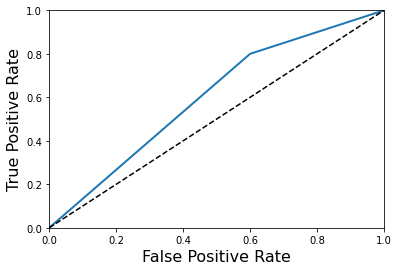

In [65]:
plot_roc_curve(false_pos, true_pos)

#### Méthode "homemade"

In [66]:
def homemade_roc_curve(y, predictions):
    thresholds = []

    false_pos = [0]
    true_pos = [0]

    for threshold in np.arange(-2, 2, 0.1):
        matrix = [0, 0, 0, 0]

        predicted = 0
        for j in range(0, len(predictions)):
            if(predictions[j] < threshold):
                predicted = -1
            else:
                predicted = 1

            if(predicted == -1 and y[j] == -1):
                matrix[0] += 1
            elif(predicted == -1 and y[j] == 1):
                matrix[1] += 1
            elif(predicted == 1 and y[j] == -1):
                matrix[2] += 1
            elif(predicted == 1 and y[j] == 1):
                matrix[3] += 1

        tp = matrix[3]
        fp = matrix[2]
        tn = matrix[0]
        fn = matrix[1]
        
        tpr = tp / (tp + fn) if tp + fn != 0 else 0
        fpr = (fp / (fp + tn)) if fp + tn != 0 else 0

        false_pos.append(fpr)
        true_pos.append(tpr)
        
        thresholds.append(threshold)
        
    return false_pos, true_pos, thresholds

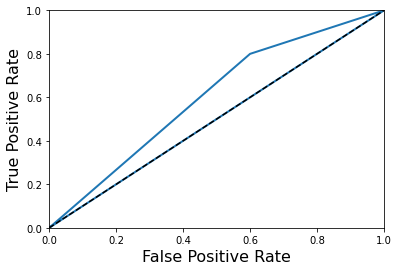

In [67]:
false_pos, true_pos, thresholds = homemade_roc_curve(virtual_resultat, virtual_prediction)
plot_roc_curve(false_pos, true_pos)

### AUC

Pour la courbe ROC, un grand taux de vrais positifs implique beaucoup de faux positifs. La diagonale en pointillée représente la courbe ROC d'un classificateur aléatoire. Un classificateur idéal s'en écarte au maximum dans le coin supérieur gauche.

C'est pourquoi on utilise comme métrique de comparaison l'air sous la courbe ROC, nommé AUC, que l'on souhaite la plus proche possible de 1.

#### Méthode "sklearn"

In [68]:
from sklearn.metrics import roc_auc_score

roc_auc_score(virtual_resultat, virtual_prediction)

0.6000000000000001

#### Méthode "homemade"

In [69]:
def homemade_auc_score(y, predictions):
    false_pos, true_pos, thresholds = homemade_roc_curve(y, predictions)
    return np.trapz(false_pos, true_pos) + 0.5

In [70]:
homemade_auc_score(virtual_resultat, virtual_prediction)

0.6000000000000001

# Étape n°3 - Entrainement des modèles

## Type de problème

L'objectif est de savoir si __oui__ ou __non__ l'employé a quitté l'entreprise en fonction de certains critères : c'est donc un problème de __classification binaire__. Les données étant fournies au préalable, le modèle de classification sera un __modèle supervisé__.

## Résolution du problème

Voici une liste de différent modèles supervisés de classification que nous allons tester :
- Le Support Vector Classifier (SVC)
- L'Arbre de décision
- La Random Forest
- La Régression logistique binaire
- Le Nearest Neighbors
- Le Perceptron
- Le RidgeClassifier
- Le SGDClassifier

L'objectif principal étant de déterminer quels sont les __critères agissant le plus sur la décision des employés__ de quitter l'entreprise. Il faut tout d'abord observer la capacité des ces différents modèles à classifier cette décision et __évaluer leur qualité__. Pour entrainer au mieux ces modèles nous allons utiliser la stratégie de la validation croisée (Cross Validation, CV).

Après avoir déterminé le meilleur modèle avec des __hyperparamètres idéaux__ (paramètres relatifs au fonctionnement d'un modèle en particulier) : les critères décisif seront mis en avant. À l'aide de ces critères précis et du meilleur modèle trouvé il sera possible de prévoir efficacement les décisions des employés.

Afin de tester l'efficacité de la librairie 'scikit-learn', des modèles vont être crées à la main.

## Importations

In [71]:
import numpy as np
import pandas as pd
import os

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

## Création de modèles
### Régression logistique
#### Méthode avec l'utilisation de 'sklearn'

In [72]:
from sklearn.linear_model import LogisticRegression

regression_sklearn = LogisticRegression(random_state=42).fit(X, y)
predictions_regression_sklearn = regression_sklearn.predict(X)

score_regresssion_sklearn = regression_sklearn.score(X, y)

#### Méthode homemade

In [73]:
class HomemadeLogisticRegression:
    def __init__(self, iterations=1000, learning_rate=0.001):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.weights = 0
        self.bias = 0
        self.predictions = []
        
    def fit(self, X, y):
        n_target, n_feature = X.shape
        self.weights = np.zeros(n_feature)
        self.bias = 0

        for i in range(self.iterations):
            linear_model = np.dot(X, self.weights) + self.bias
            predictions = 1 / (1 + np.exp(-linear_model))

            gradientA = (1 / n_target) * np.dot(X.T, (predictions - y))
            gradientB = (1 / n_target) * np.sum(predictions - y)

            self.weights -= self.learning_rate * gradientA
            self.bias -= self.learning_rate * gradientB
        
        return self
    
    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        predictions = 1 / (1 + np.exp(-linear_model))
        predictions_classified = [1 if j > 0 else -1 for j in predictions]
        
        self.predictions = predictions_classified
        
        return np.array(predictions_classified)

    def score(self, X, y):        
        return np.sum(y == self.predictions) / len(y)

In [74]:
regression_homemade = HomemadeLogisticRegression().fit(X, y)
predictions_homemade = regression_homemade.predict(X)

score_regresssion_homemade = regression_homemade.score(X, y)

#### Comparaison des deux méthodes

In [75]:
print("sklearn score :", score_regresssion_sklearn)
print("homemade score :", score_regresssion_homemade)

sklearn score : 0.8496598639455782
homemade score : 0.7145124716553288


### Perceptron simple
#### Méthode avec l'utilisation de 'sklearn'

In [76]:
from sklearn.linear_model import Perceptron

perceptron_sklearn = Perceptron(random_state=42).fit(X, y)
predictions_sklearn = perceptron_sklearn.predict(X)

score_perceptron_sklearn = regression_sklearn.score(X,y)

#### Méthode homemade

In [77]:
class HomemadePerceptron:
    def __init__(self, iterations=1000, rate=0.001):
        self.iterations = iterations
        self.rate = rate
    
    def perceptron(self, X):
        return [1 if j == 1 else -1 for j in (X.dot(self.omega) + self.bias)]
    
    def fit(self, X, y):
        self.omega = np.random.rand(X.shape[1])
        self.bias = np.random.randn(1)
        
        for i in range(self.iterations):
            predicted = self.perceptron(X)

            dw = (1 / len(self.omega)) * np.dot(X.T, (predicted - y))
            db = (1 / len(self.omega)) * np.sum(predicted - y)

            self.omega -= self.rate * dw
            self.bias -= self.rate * db
        
        return self
    
    def predict(self, X):
        self.predictions = self.perceptron(X)
        
        return np.array(self.predictions)

    def score(self, X, y):        
        return np.sum(y == self.predictions) / len(y)

In [78]:
perceptron_homemade = HomemadePerceptron().fit(X, y)
predictions_perceptron_homemade = perceptron_homemade.predict(X)

score_perceptron_homemade = perceptron_homemade.score(X, y)

#### Comparaison des deux méthodes

In [79]:
print("sklearn score :", score_perceptron_sklearn)
print("homemade score :", score_perceptron_homemade)

sklearn score : 0.8496598639455782
homemade score : 0.8387755102040816


Avec un score presque équivalent, il est possible de déduire que sklearn retourne des résultats fiables.

## Résolution du problème avec plusieurs modèles
### Validation croisée (Cross Validation) : le paramètre k

Ce paramètre sera utilisé partout où la validation croisée sera nécessaire. Celui-ci indique le nombre $k$ de partition de taille égale qui sera découpé depuis les données initiales. Par convention, nous allons utiliser $k=10$.

Cette valeur est très couramment utilisée et est conseillée par de nombreux spécialistes dans le domaine. (*Page 70, Applied Predictive Modeling & Page 184, An Introduction to Statistical Learning*).

### Hyperparamètres
#### Hyperparamètres des modèles

L'objectif est de connaitre la valeur des hyperparamètres les plus pertinents en fonction des modèles appliqués à ce problème, certains d'entre eux sont utilisés presque partout, d'autres sont plus spécifiques à un modèle. Voici une définition de ceux que nous allons utiliser ainsi qu'une liste de valeur possible que nous appliquerons dans le code.

Chaque valeur a été choisie autour de la valeur par défaut fourni par les algorithmes. Tout en respectant un certain pas d'une valeur à une autre d'un même hyperparamètre. Ces hyperparamètres seront testés et évalués par la suite grâce à la méthode `GridSearchCV`. Cette méthode va aussi nous fournir quels seront les meilleurs hyperparamètres en fonction du meilleur score trouvé (le classement du score sera en fonction de l'accuracy, cependant, tous les indicateurs seront calculés). Enfin, nous comparerons ces scores afin de déterminer le meilleur modèle. 

##### Cas globaux

Rassemble les hyperparamètres utilisés sur l'ensemble des modèles sauf les modèles suivants : "<u>Nearest Neighbors</u>", "<u>Arbre de décision</u>" et "<u>Random Forest</u>"

- L'hyperparamètre `tol` définit la tolérance pour le critère d'arrêt. Il indique donc à l'algorithme d'arrêter la convergeance une fois qu'une certaine tolérance est atteinte. Plus la tolérance est petite, plus l'algorithme mettra du temps à converger. Il prendra les valeurs possible suivantes : $0.1, 0.01, 0.001, 0.0001, 0.00001$

- L'hyperparamètre `max_iter`, celui-ci définit le maximum d'itération maximale dans la convergeance vers la tolérance donnée afin d'éviter les boucles infinies. Il prendra les valeurs possibles suivantes : $500, 1000, 1500, 2000$ 

Cas exceptionnel pour l'hyperparamètre `max_iter`:

La valeur par défaut de `max_iter` étant plus petite dans le modèle "<u>Régression logistique binaire</u>", le pas sera lui aussi plus petit. Voici donc les valeurs utilisées dans ce cas précis : $100, 200, 300, 400, 500, 600$

##### SVC

En plus des trois hyperparamètres cités précédemment, un de plus va être utilisé: il s'agit de l'hyperparamètre `kernel` celui-ci spécifie le type de noyau à utiliser dans l'algorithme. Il est au centre du fonctionnement du SVC et affecte grandement la séparabilité des classes ainsi que la performance de l'algorithme. Il prendra les valeurs possible suivantes : `'linear'`, `'poly'`, `'sigmoid'`, `'rbf'`.

##### DecisionTreeClassifier

Il s'agit ici de faire varier deux hyperparamètres, `splitter` et `max_features`.

- l'hyperparamètre `splitter` spécifie la stratégie utilisée pour choisir la méthode de fractionnement à chaque nœud. En plus d'agir sur la performance, celui-ci va permettre de fournir des résultats inédits (car l'aléatoire rentre en compte). Il prendra deux valeurs possibles qui sont les suivantes : `'best'` et `'random'`

- l'hyperparamètre `max_features` spécifie le nombre maximal de critères qui vont être utilisés lors de la création de l'arbre. Le maximum (5) est représenté par le nombre de critères totaux dans le dataset. Celui-ci prendra les valeurs suivantes : $1, 2, 3, 4, 5$

##### RandomForestClassifier

Ce modèle, quant à lui, va se voir faire varier trois hyperparamètres, `n_estimators`, `max_features` et `bootstrap`.

- l'hyperparamètre `n_estimators` spécifie le nombre d'arbre dans la fôret, c'est à dire le nombre d'échantillons sur lesquels cet algorithme va travailler. Il prendra les valeurs suivantes : $100, 200, 300, 400$

- l'hyperparamètre `max_features` est le même que pour le modèle "<u>DecisionTreeClassifier</u>"

- l'hyperparamètre `bootstrap` spécifie si des échantillons seront utilisés lors de la construction des arbres. Sinon l'ensemble des données est utilisé pour construire chaque arbre. Celui-ci prendra deux valeurs possibles suivantes : `True` et `False`

##### KNeighborsClassifier

Nous allons utiliser un hyperparamètre : `n_neighbors`. Celui-ci spécifie le nombre de voisins à utiliser par défaut pour les requêtes kneighbors. Celui-ci est très important, car il agit directement avec l'accuracy du modèle. Il prendra les valeurs possibles suivantes : $2, 4, 6, 8, 10, 12, 14, 16, 18, 20$

##### SGDClassifier

En plus des deux hyperparamètres cités dans les cas globaux, l'hyperparamètre `alpha` sera utilisé. Il définit la constante qui multiplie le terme de régularisation qui va agir sur le pas d'apprentissage de l'algorithme et donc la façon dont il va converger vers le minimum. Celui-ci prendra les valeurs suivantes : $0.01, 0.001, 0.0001, 0.00001$

In [80]:
from sklearn.metrics import classification_report
bests = {}
def models(models, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .20, random_state = 100)
    data = {
        "parameters": [],
        "predict": [],
        "confusion_matrix": [],
        "precision": [],
        "recall" : [],
        "specificity": [],
        "fpr": [],
        "fnr": [],
        "accuracy": [],
        "f1-score": [],
        "npv": [],
        "fdr": [],
        "auc": [],
        "roc-parameters": []
    }
    for model in models:        
        path = "./outputs/models/"+ model["name"]
        if not os.path.isdir(path):
            os.makedirs(path)
        
        print(model["name"] + " : ")
        print("Start training...")
        
        search = GridSearchCV(
            model["method"],
            model["parameters"],
            cv=10,
            scoring='accuracy'
        )
        
        
        search.fit(X_train, y_train)
        print("Done!")
        
        data["parameters"].append(search.best_params_)
        model_predict = search.best_estimator_.predict(X_test)
        
        confusion = homemade_confusion_matrix(y_test, model_predict)
                
        data["predict"].append(model_predict)
        data["confusion_matrix"].append(confusion)
        
        precision = homemade_precision_score(y_test, model_predict)
        recall = homemade_recall_score(y_test, model_predict)
        
        data["precision"].append(precision)
        data["recall"].append(recall)
        data["specificity"].append(homemade_specificity_score(y_test, model_predict))
        data["fpr"].append(homemade_fpr_calculator(y_test, model_predict))
        data["fnr"].append(homemade_fnr_calculator(y_test, model_predict))
        data["accuracy"].append(homemade_accuracy_score(y_test, model_predict))
        data["f1-score"].append(homemade_f1_score(precision, recall))
        data["npv"].append(homemade_npv_calculator(y_test, model_predict))
        data["fdr"].append(homemade_fdr_calculator(y_test, model_predict))
        
        false_pos, true_pos, thresholds = roc_curve(y_test, model_predict)
        
        data["auc"].append(roc_auc_score(y_test, model_predict))
        data["roc-parameters"].append({
            "false_pos": false_pos,
            "true_pos": true_pos,
            "thresholds": thresholds
        })
        
        bests.update({model["name"]: search.best_estimator_})
    
    return pd.DataFrame(data, index=pd.DataFrame(models)["name"].to_numpy())

In [81]:
models_indicators = models(
    [
        { # 180
            'name': 'DecisionTreeClassifier',
            'method': DecisionTreeClassifier(random_state=100),
            "parameters": {
                "splitter": ["best", "random"],
                "max_features": [1, 2, 3, 4, 5]
            }
        },
        { # 200
            'name': 'KNeighborsClassifier',
            'method': KNeighborsClassifier(),
            "parameters": {
                "n_neighbors": [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
                "weights": ["uniform", "distance"],
            }
        },
        { # 200
            'name': 'Ridge',
            'method': RidgeClassifier(random_state=100),
            "parameters": {
                "max_iter": [500, 1000, 1500, 2000],
                "tol": [0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
        },
        { # 720
            'name': 'RandomForestClassifier',
            'method': RandomForestClassifier(random_state=100),
            "parameters": {
                "n_estimators": [100, 200, 300, 400] ,
                "max_features": [1, 2, 3, 4, 5] ,
                "bootstrap": [True, False],
            }
        },
        { # 800
            'name': 'Perceptron',
            'method': Perceptron(random_state=100),
            "parameters": {
                "max_iter": [500, 1000, 1500, 2000],
                "n_iter_no_change": [5, 10, 15, 20],
                "tol": [0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
        },
        { # 800
            'name': 'SGDClassifier',
            'method': SGDClassifier(random_state=100),
            "parameters": {
                "max_iter": [500, 1000, 1500, 2000],
                "n_iter_no_change": [5, 10, 15, 20],
                "tol": [0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
        },
        { # 800
            'name': 'SVC',
            'method': SVC(random_state=100),
            "parameters": {
                "max_iter": [500, 1000, 1500, -1] ,
                "kernel": ["linear", "poly", "sigmoid", "rbf"],
                "tol": [0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
        },
        { # 900
            'name': 'LogisticRegression',
            'method': LogisticRegression(random_state=100),
            "parameters": {
                "max_iter": [100, 200, 300, 400, 500, 600],
                "solver": ["sag", "liblinear", "saga"],
                "tol": [0.1, 0.01, 0.001, 0.0001, 0.00001],
            }
        }
    ],
    X.to_numpy(),
    y.to_numpy()
)

DecisionTreeClassifier : 
Start training...
Done!
KNeighborsClassifier : 
Start training...
Done!
Ridge : 
Start training...
Done!
RandomForestClassifier : 
Start training...
Done!
Perceptron : 
Start training...
Done!
SGDClassifier : 
Start training...
Done!
SVC : 
Start training...
Done!
LogisticRegression : 
Start training...
Done!


In [82]:
models_indicators.to_csv("./outputs/models/indicators.csv")

,parameters,predict,confusion_matrix,precision,recall,specificity,fpr,fnr,accuracy,f1-score,npv,fdr,auc,roc-parameters
DecisionTreeClassifier,"{'max_features': 3, 'splitter': 'random'}","[-1, -1, -1, -1, -1, 1, 1, 1, -1, -1, -1, -1, ...","[[103, 31], [38, 710]]",0.730496,0.768657,0.949198,0.050802,0.231343,0.921769,0.749091,0.958165,0.269504,0.858927,"{'false_pos': [0.0, 0.05080213903743316, 1.0],..."
KNeighborsClassifier,"{'n_neighbors': 10, 'weights': 'distance'}","[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1...","[[54, 80], [23, 725]]",0.701299,0.402985,0.969251,0.030749,0.597015,0.883220,0.511848,0.900621,0.298701,0.686118,"{'false_pos': [0.0, 0.03074866310160428, 1.0],..."
Ridge,"{'max_iter': 500, 'tol': 0.1}","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0, 134], [0, 748]]",NaN,0.000000,1.000000,0.000000,1.000000,0.848073,NaN,0.848073,NaN,0.500000,"{'false_pos': [0.0, 1.0], 'true_pos': [0.0, 1...."
RandomForestClassifier,"{'bootstrap': False, 'max_features': 1, 'n_est...","[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1...","[[97, 37], [17, 731]]",0.850877,0.723881,0.977273,0.022727,0.276119,0.938776,0.782258,0.951823,0.149123,0.850577,"{'false_pos': [0.0, 0.022727272727272728, 1.0]..."
Perceptron,"{'max_iter': 500, 'n_iter_no_change': 5, 'tol'...","[-1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, -1, -...","[[63, 71], [143, 605]]",0.305825,0.470149,0.808824,0.191176,0.529851,0.757370,0.370588,0.894970,0.694175,0.639486,"{'false_pos': [0.0, 0.19117647058823528, 1.0],..."
SGDClassifier,"{'max_iter': 1000, 'n_iter_no_change': 20, 'to...","[-1, -1, -1, 1, -1, 1, 1, 1, -1, -1, -1, 1, -1...","[[61, 73], [152, 596]]",0.286385,0.455224,0.796791,0.203209,0.544776,0.744898,0.351585,0.890882,0.713615,0.626008,"{'false_pos': [0.0, 0.20320855614973263, 1.0],..."
SVC,"{'kernel': 'linear', 'max_iter': -1, 'tol': 0.1}","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -...","[[0, 134], [0, 748]]",NaN,0.000000,1.000000,0.000000,1.000000,0.848073,NaN,0.848073,NaN,0.500000,"{'false_pos': [0.0, 1.0], 'true_pos': [0.0, 1...."
LogisticRegression,"{'max_iter': 100, 'solver': 'liblinear', 'tol'...","[-1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1...","[[17, 117], [4, 744]]",0.809524,0.126866,0.994652,0.005348,0.873134,0.862812,0.219355,0.864111,0.190476,0.560759,"{'false_pos': [0.0, 0.0053475935828877, 1.0], ..."


# Étape n°4 - Interprétation des résultats

## Selection du meilleur modèle

### Classement à partir de l'accuracy

Après avoir recueillis les meilleurs hyperparamètres de chaque modèle grâce à la méthode GridSearchCV (celle-ci se fiant uniquement à l'indicateur 'accuracy' donné en paramètre), un premier classement des meilleurs modèles peut déjà être établis. 

In [119]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def display_info(infos, titles, labels, ymax=1.2, ylabel=''):
    fig, axs = plt.subplots(nrows=1, ncols=len(titles), figsize=(24, 6))
    
    if (len(titles) > 1):
        for j in range(0, len(titles)):
            axs[j] = give_data_to_display_as_hist(infos[j], labels, titles[j].capitalize(), axs[j], fig, 'C'+str(j), ymax, ylabel)
    else:
        axs = give_data_to_display_as_hist(infos, labels, titles[0].capitalize(), axs, fig, 'C1', ymax, ylabel)
    
    save_fig("./outputs/"+ ylabel + "_result")
    plt.show()

def give_data_to_display_as_hist(array, labels, title, ax, fig, color="C1", ymax=1.2, what=''):
    ind = list(np.arange(len(array)))
    bars = ax.bar(ind, array, 0.5, color=color)
    ax.set_title(title, fontsize=16)
    ax.set_xlim(-0.5, len(ind) + 0.5)
    ax.set_ylim(0, ymax)
    ax.set_ylabel(what)
    ax.set_xlim(-0.5, 3.5)
    ax.set_xticks(ind)
    ax.set_xticklabels(labels, fontsize=16)
    for rect in ax.patches:
        height = rect.get_height()
        if (np.issubdtype(height, np.integer) == False):
            height = np.around(height, 3)
        ax.annotate(height, xy=(rect.get_x()+rect.get_width()/2, height), xytext=(0, 5), textcoords='offset points', ha='center', va='bottom')
    return ax;

def plot_roc_curve(false_pos, true_pos, ax, title=''):
    ax.plot(false_pos, true_pos, linewidth=2)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.axis([0, 1, 0, 1])
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)
    return ax

In [84]:
datas = models_indicators
datas_accuracy_sorted = datas.sort_values(by='accuracy', ascending=False)

In [85]:
datas_accuracy_sorted[['accuracy']]

,accuracy
RandomForestClassifier,0.938776
DecisionTreeClassifier,0.921769
KNeighborsClassifier,0.883220
LogisticRegression,0.862812
Ridge,0.848073
SVC,0.848073
Perceptron,0.757370
SGDClassifier,0.744898


D'après le classement, les modèles <u>DecisionTreeClassifier</u>, <u>KNeighborsClassifier</u> et <u>RandomForestClassifier</u> obtiennent un très bon score d'accuracy. Il est donc nécessaire de regarder en détails les différents scores.
### Classement à partir de la precision, recall et F1-Score

In [86]:
datas_precision_sorted = datas.sort_values(by='precision', ascending=False)
datas_precision_sorted[['precision']]

,precision
RandomForestClassifier,0.850877
LogisticRegression,0.809524
DecisionTreeClassifier,0.730496
KNeighborsClassifier,0.701299
Perceptron,0.305825
SGDClassifier,0.286385
Ridge,NaN
SVC,NaN


In [87]:
datas_recall_sorted = datas.sort_values(by='recall', ascending=False)
datas_recall_sorted[['recall']]

,recall
DecisionTreeClassifier,0.768657
RandomForestClassifier,0.723881
Perceptron,0.470149
SGDClassifier,0.455224
KNeighborsClassifier,0.402985
LogisticRegression,0.126866
Ridge,0.000000
SVC,0.000000


In [88]:
datas_f1_sorted = datas.sort_values(by='f1-score', ascending=False)
datas_f1_sorted[['f1-score']]

,f1-score
RandomForestClassifier,0.782258
DecisionTreeClassifier,0.749091
KNeighborsClassifier,0.511848
Perceptron,0.370588
SGDClassifier,0.351585
LogisticRegression,0.219355
Ridge,NaN
SVC,NaN


D'après les classements, les modèles <u>Ridge</u> et <u>SVC</u> fournissent un score incohérent (NaN ou 0), ils ne seronts donc pas sélectionnés dans les prochaines étapes. L'indicateur **recall** représentant le pourcentage d'employés quittant l'entreprise et étant bien détectés comme partant l'entreprise est donc celui qui nous interesse le plus. Cependant, il faut que le modèle reste aussi **précis** (accuracy). Les modèles sélectionnés sont donc les suivants : <u>RandomForestClassifier</u>, <u>DecisionTreeClassifier</u>, <u>Perceptron</u> et <u>KNeighborsClassifier</u>

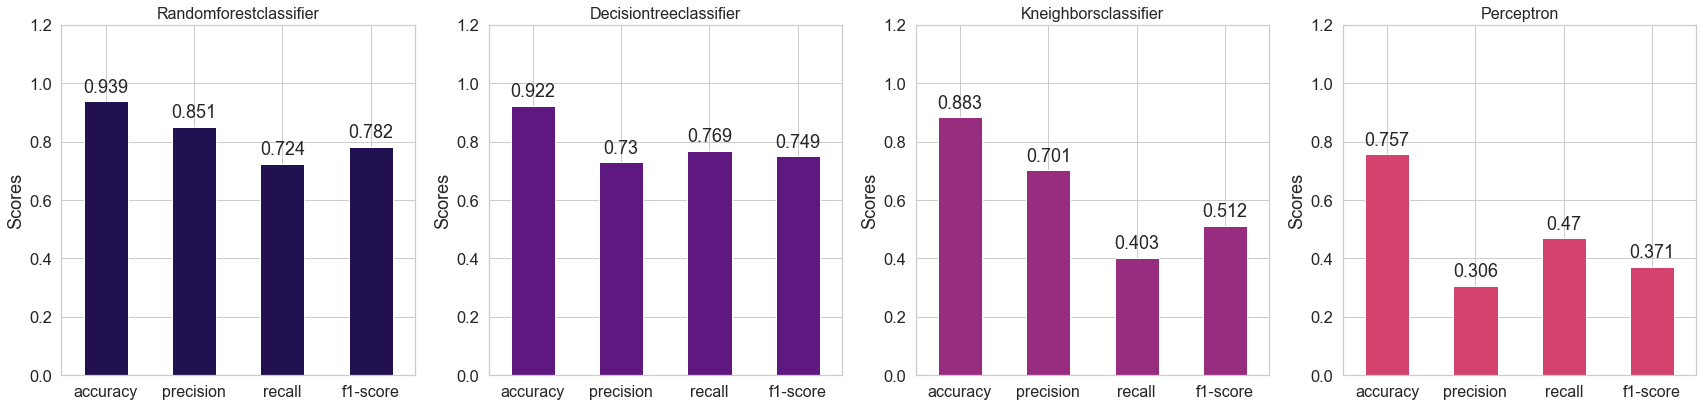

In [120]:
datas = datas_f1_sorted.head(4)
titles = ['accuracy', 'precision', 'recall', 'f1-score']
display_info(list(datas[titles].values), list(datas.index), titles, 1.2, 'Scores')

### Courbe ROC et AUC

Courbes ROC


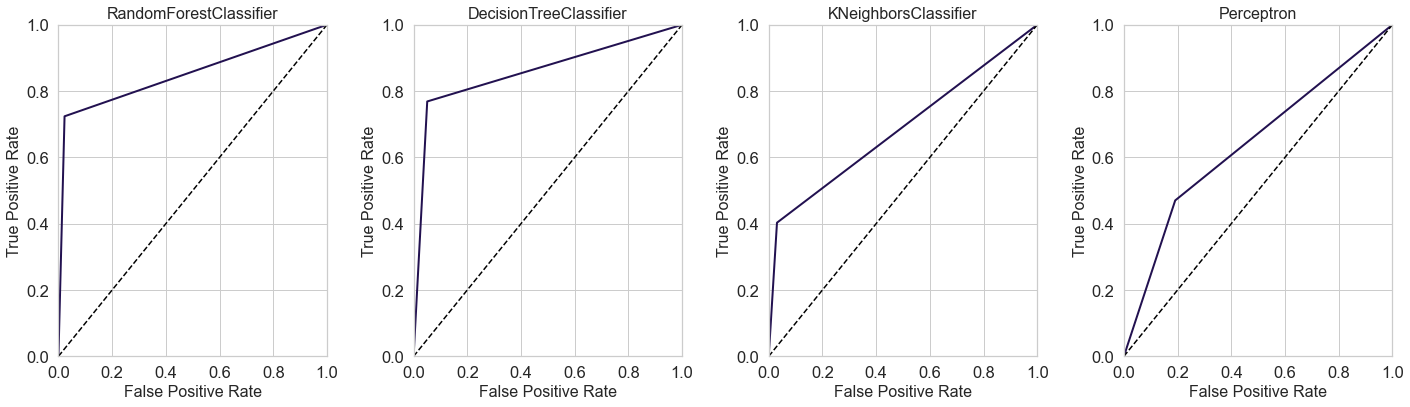

In [121]:
all_roc_params = list(datas['roc-parameters'].values)
fig, axs = plt.subplots(nrows=1, ncols=len(all_roc_params), figsize=(20, 6))
for i in range(0, len(all_roc_params)):
    axs[i] = plot_roc_curve(all_roc_params[i]['false_pos'], all_roc_params[i]['true_pos'], axs[i], list(datas.index)[i])

print("Courbes ROC")
save_fig("./outputs/all_roc_result")
plt.show()

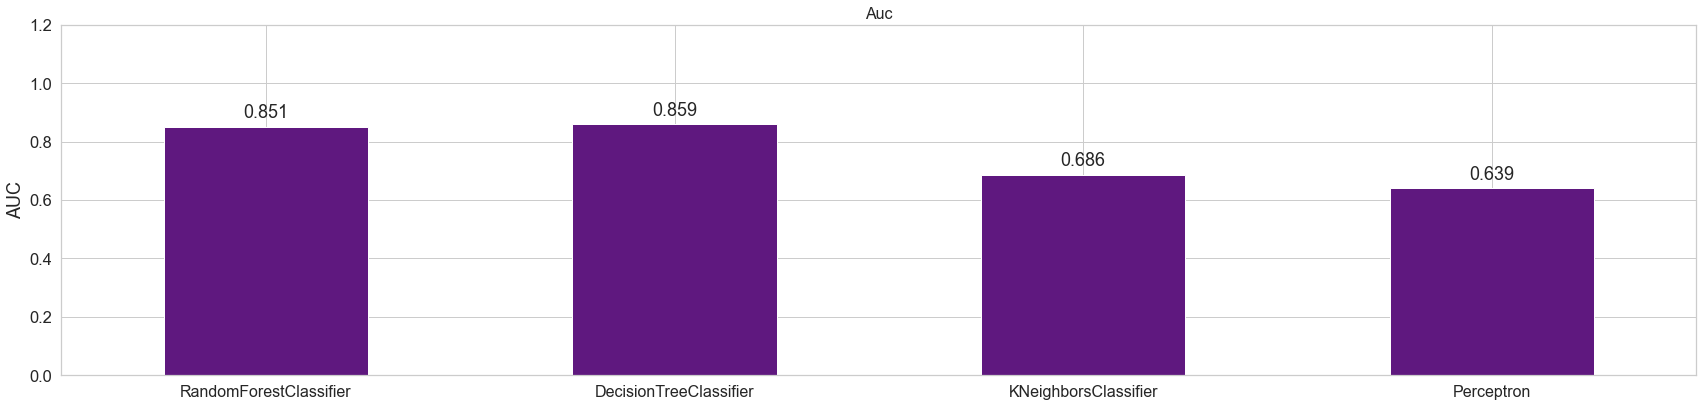

In [122]:
display_info(list(datas.auc.values), ["AUC"], list(datas.index), 1.2, 'AUC')

D'après les courbes ROC, les <u>DecisionTreeClassifier</u>, <u>RandomForestClassifier</u> obtiennent un score AUC supérieur à 80%. Il va donc falloir départager ces deux modèles restant afin d'en sélectionner un seul.

### Sélection parmi les modèles restants

Il va falloir départager les modèles restant en prenant autre chose en compte que les indicateurs de qualité. Cela passe par l'observation de la différence performance en temps d'exécution de ceux-ci.

In [125]:
# Importation des libraries
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

##### Calcul de la performance du modèle "DecisionTreeClassifier"

In [126]:
start = time.time_ns()
dtc = bests["DecisionTreeClassifier"]
dtc.fit(X_train, y_train)
dtc.predict(X_test)
end = time.time_ns()
dtc_time = (end - start) / 10**6
# Temps en ms
dtc_time

6.9809

##### Calcul de la performance du modèle "RandomForestClassifier"

In [127]:
start = time.time_ns()
rfc = bests["RandomForestClassifier"]
rfc.fit(X_train, y_train)
rfc.predict(X_test)
end = time.time_ns()
rfc_time = (end - start) / 10**6
# Temps en ms
rfc_time

601.6848

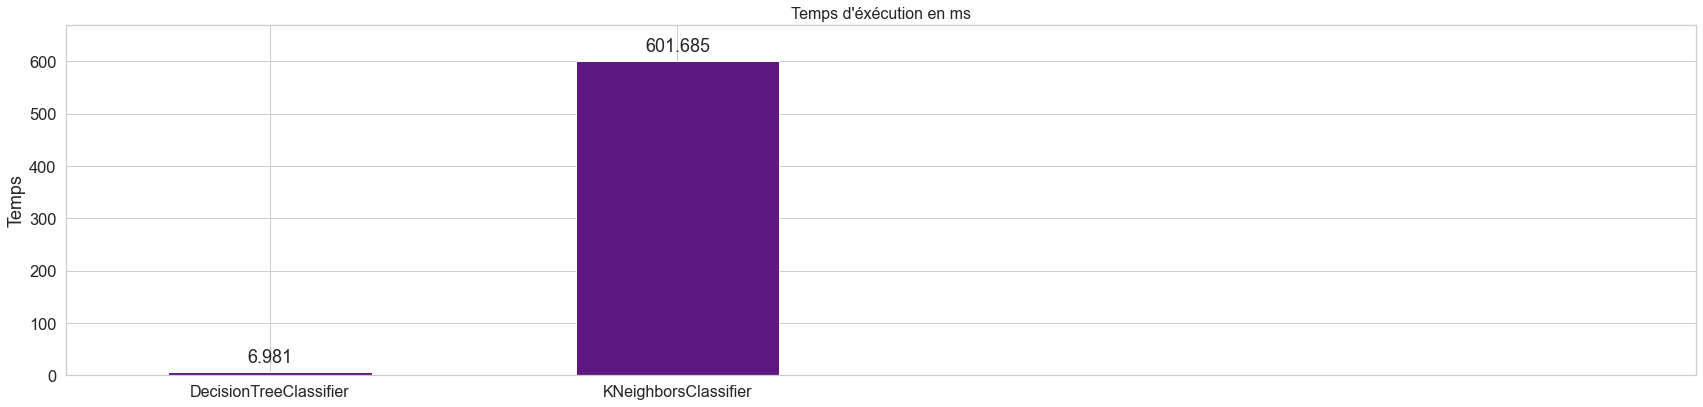

In [134]:
display_info([dtc_time, rfc_time], ["Temps d'éxécution en ms"], ["DecisionTreeClassifier", "KNeighborsClassifier"], 670, 'Temps')

### Conclusion
Le modèle "<u>DecisionTreeClassifier</u>" est plus rapide que le modèle "<u>KNeighborsClassifier</u>"

In [130]:
dtc_time < rfc_time

True

Après analyse, les conclusions qui ont été apportées sur le choix du modèle reprennent les principaux axes de performances.
- La précision
- La justesse
- La rapidité

Le modèle choisi est donc le "<u>DecisionTreeClassifier</u>" car ses métriques présentent un score élevé comme sa précision (Accuracy) à 92.2% et sa justesse (Recall) à 76.9%. Cependant, ce n'est pas ce qui va déterminer le choix final. Étant donné que le modèle "<u>RandomForestClassifier</u>" possède des scores tout aussi élevé, la décision finale s'est axée sur la performance en termes de rapidité : cela représente le temps d'exécution de "<u>DecisionTreeClassifier</u>". Son temps d'exécution de 6.98 ms est plus rapide de 601.68 ms par rapport au modèle "<u>RandomForestClassifier</u>".

Cela prouve une fois de plus que le modèle le plus adapté pour les besoins de l'entreprise HumanForYou est "<u>DecisionTreeClassifier</u>".


## Sélection du critère agissant le plus sur la décision des employés

In [101]:
import pandas as pd

data = {
    'Feature': list(X.columns),
    'Importance': list(bests["DecisionTreeClassifier"].feature_importances_)  
}

selector = pd.DataFrame(data)
selector = selector.sort_values(by='Importance', ascending=False)
selector

,Feature,Importance
4,AttendanceScore,0.325965
0,TotalWorkingYears,0.254763
1,YearsAtCompany,0.183759
2,YearsWithCurrManager,0.159362
3,EnvironmentSatisfaction,0.076151


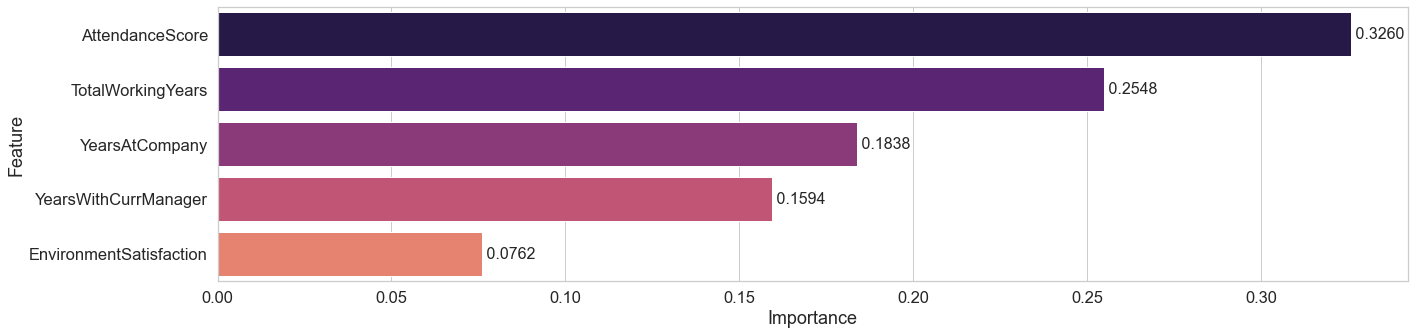

In [131]:
fig, ax = plt.subplots(figsize=(20, 5))
sns.set(style='whitegrid', palette='magma', font_scale=1.5)
sns.barplot(y='Feature', x='Importance', data=selector, ax=ax)
ax.bar_label(ax.containers[-1], fmt=' %.4f', label_type='edge', fontsize=16)

save_fig('./outputs/featureRank')

Visiblement, le facteur agissant le plus sur la décision du modèle est le critère *AttendanceScore* suivis par le critère *TotalWorkingYears*.

## Interprétation des résultats

Les facteurs agissant le plus sur le départ des employés concernent notamment : le nombre d'années d'expérience en entreprise pour le même type de poste ainsi que leur assiduité dans l'entreprise.

L'algorithme pourrait obtenir des résultats différents si la taille des données était plus grande.

## Piste de solutions

En plus de faire les sondages de satisfaction annuels, l'idéal serait de demander plus de détails sur le bien-être de l’employé dans l'entreprise, que ce soit à propos de son environnement, des relations humaines ou encore du poste occupé en lui-même. Prendre en compte ces détails sera utile pour améliorer la qualité de vie des employés et ainsi leur donner envie de rester. Il serait aussi nécessaire d'augmenter la fréquence de ces sondages en les rendant semestriels. Ensuite, diversifier les missions sur un poste, donner plus de responsabilités ou réorienter la personne si celle-ci n’est pas épanouie sur ce poste. Cela permettra de rompre les actions répétitives et de donner de l'importance à la personne. Si le travail est bien fait, il ne faut pas hésiter à récompenser le travail effectué. Enfin, si tous ces conseils sont appliqués, l'assiduité aura de grandes chances d'augmenter et moins d'employés voudront quitter les équipes.

## Conclusion

Pour conclure, cette intelligence artificielle retourne bien un résultat cohérent en représentant les critères dans l'ordre de l'histogramme ci-dessus. Cependant, il ne faut pas oublier que cet outil a été conçu dans l'optique d'informer l'utilisateur. En aucun cas cette IA ne doit avoir un pouvoir de décision sur les mesures adoptées suite à la prise de connaissance des données qu'elle fournit à l'entreprise. L'humain reste le seul et unique décisionnaire final.